In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random as rnd
from scipy.stats import binom, norm , poisson, expon , moment

import numba as nb
from numba.experimental import jitclass
from numba.types import float64, int64

In [4]:
@jitclass([('end', float64),
           ('dt', float64),
           ('paths', int64)])
class WeinerGenParameters:
    def __init__(self, end, dt, paths):
        self.end = end
        self.dt = dt
        self.paths = paths
        
    def steps(self):
        return int64(self.end / self.dt)

@nb.njit(parallel = True)
def wiener(wp):
    steps = wp.steps() + 1
    arr = np.zeros((steps, wp.paths))
    for n in nb.prange(wp.paths):
        for i in range(0, steps):
            arr[i + 1, n] = arr[i, n] + np.random.normal(loc = 0, scale = (wp.dt) ** .5)
    return arr 

In [65]:
@nb.njit(parallel = True)
def integrate_ito(process_increment,wiener_increment):
    n = len(wiener_increment[:,0]) - 1
    k = np.empty(shape =(n,1))
    for i in nb.prange(n):
        k[i] = process_increment[i,0]  * (wiener_increment[(i + 1), 0] - wiener_increment[i, 0])
    return k

@nb.njit(parallel = True)
def integrate_stratonovich(wiener_increment):
    n = len(wiener_increment[:,0]) - 1
    k = np.empty(shape =(n,1))
    for i in nb.prange(n-1):
        k[i] = ((wiener_increment[i+1, 0] - wiener_increment[i, 0]) *
                (process_increment[i+1, 0] + process_increment[i, 0]) * .5)
    return k

@nb.njit(parallel = True)
def quad_variation(process_increment):
    n = len(process_increment) - 1
    k = np.empty(shape =(n,1))
    for i in nb.prange(n):
        k[i] =  (process_increment[i+1] - process_increment[i]) ** 2
    return k

In [6]:
wp_1 = WeinerGenParameters(end = 1., dt = .0000001, paths = 1)   
wp_5 = WeinerGenParameters(end = 5., dt = .0000005, paths = 1)   
wp_10 = WeinerGenParameters(end = 10., dt = .000001, paths = 1)   

arr_1 = wiener(wp_1)
arr_5 = wiener(wp_5)
arr_10 = wiener(wp_10)

# Ito integral

In [51]:
print(f'''t = {wp_1.end}\nIto approximation: {integrate_ito(arr_1).sum()}\nIto theoretical value: {arr_1[-1][0] ** 2 / 2 - wp_1.end / 2}\n-----------------------''')
print(f'''t = {wp_5.end}\nIto approximation: {integrate_ito(arr_5).sum()}\nIto theoretical value: {arr_5[-1][0] ** 2 / 2 - wp_5.end / 2}\n-----------------------''')
print(f'''t = {wp_10.end}\nIto approximation: {integrate_ito(arr_10).sum()}\nIto theoretical value: {arr_10[-1][0] ** 2 / 2 - wp_10.end / 2}\n-----------------------''')

t = 1.0
Ito approximation: -0.30498166674568106
Ito theoretical value: -0.30528456332199094
-----------------------
t = 5.0
Ito approximation: -2.493741028066918
Ito theoretical value: -2.492339883898141
-----------------------
t = 10.0
Ito approximation: -4.359020713310215
Ito theoretical value: -4.359191702167793
-----------------------


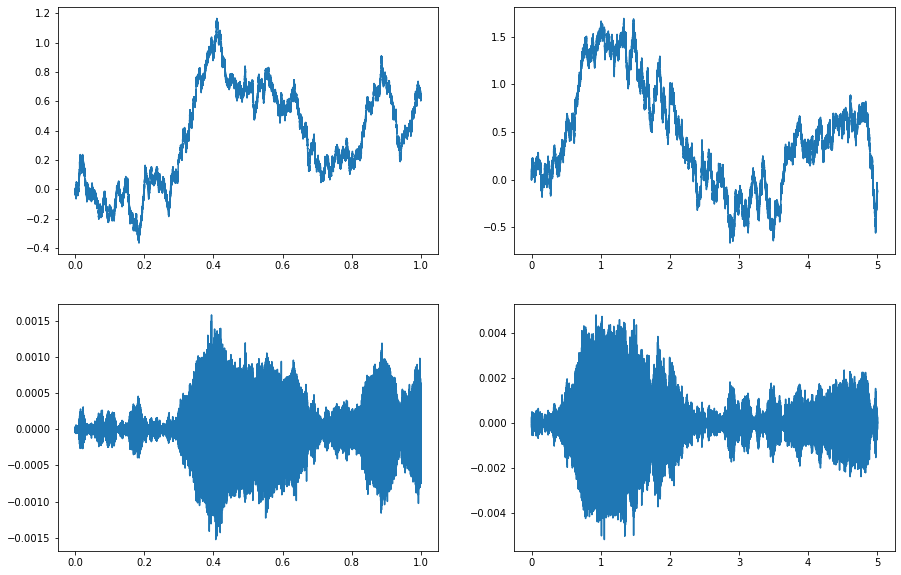

In [36]:
fig = plt.figure(figsize=(15,10))
ax = fig.subplots(nrows=2, ncols=2)
ax[0,0].plot(np.linspace(0, wp_1.end, wp_1.steps() + 1), arr_1)
ax[1,0].plot(np.linspace(0, wp_1.end, wp_1.steps()), integrate_ito(arr_1))

ax[0,1].plot(np.linspace(0, wp_5.end, wp_5.steps() + 1), arr_5)
ax[1,1].plot(np.linspace(0, wp_5.end, wp_5.steps()), integrate_ito(arr_5));

# Stratonovich integral

In [67]:
integrate_stratonovich(arr_1,arr_1).sum()

0.19467574595988724

In [39]:
print(f'''t = {wp_1.end}\nStratonovich approximation: {integrate_stratonovich(arr_1,arr_1).sum()}\nIto theoretical value: {arr_1[-1][0] ** 2 / 2 - wp_1.end / 2}\n-----------------------''')
print(f'''t = {wp_5.end}\nStratonovich approximation: {integrate_stratonovich(arr_5,arr_5).sum()}\nIto theoretical value: {arr_5[-1][0] ** 2 / 2 - wp_5.end / 2}\n-----------------------''')
print(f'''t = {wp_10.end}\nStratonovich approximation: {integrate_stratonovich(arr_10,arr_10).sum()}\nIto theoretical value: {arr_10[-1][0] ** 2 / 2 - wp_10.end / 2}\n-----------------------''')

t = 1.0
Stratonovich approximation: 0.19471543667800906
Ito theoretical value: -0.30528456332199094
-----------------------
t = 5.0
Stratonovich approximation: 0.0076601161018588
Ito theoretical value: -2.492339883898141
-----------------------
t = 10.0
Stratonovich approximation: 0.6408082978322065
Ito theoretical value: -4.359191702167793
-----------------------


In [ ]:
fig = plt.figure(figsize=(15,10))
ax = fig.subplots(nrows=2, ncols=2)
ax[0,0].plot(np.linspace(0, wp_1.end, wp_1.steps() + 1), arr_1)опоеоо
ax[1,0].plot(np.linspace(0, wp_1.end, wp_1.steps()), integrate_stratonovich(arr_1))

ax[0,1].plot(np.linspace(0, wp_5.end, wp_5.steps() + 1), arr_5)
ax[1,1].plot(np.linspace(0, wp_5.end, wp_5.steps()), integrate_stratonovich(arr_5));

# Quad variation of X_t = tW_t process convergence to theoretical value

In [34]:
martl_1 = [arr_1[i][0] * i * wp_1.dt for i in range(wp_1.steps() + 1)]
print(f'''t = {wp_1.end}\nQuadratic variation approximation: {sum(quad_variation(martl_1))[0]}\nQuadratic variation theoretical value: {wp_1.end ** 3 / 3}\n-----------------------''')

t = 1.0
Quadratic variation approximation: 0.33335916879749156
Quadratic variation theoretical value: -0.30528456332199094
-----------------------
